### Instrucciones generales <a class="tocSkip"></a>
1. Forme un grupo de **máximo dos estudiantes**
1. Copie este notebook y **modifique el nombre de archivo** agregando los apellidos de ambos miembros. Por ejemplo si los miembros del grupo son Pablo Huijse y Ana Nuñez el nombre sería: `info147_tarea2_huijse_nuñez.ipynb`
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña Puede agregar a su compañero en la pestaña *Settings/Manage access*
1. Sean leales y honestos, no copie los resultados de otros grupos, el único afectado es usted
1. Se evaluará el último commit antes de la fecha y hora de entrega

# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







## Introducción

En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos

En esta tarea ustedes analizarán datos para comprobar o refutar los hallazgos de *D. Treisman*

## Datos

Para esta tarea se les provee de un conjunto de datos indexado por país con los siguientes atributos
- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [1]:
import pandas as pd
df = pd.read_csv('billonarios.csv', index_col='pais')
df.head(20)

,nbillonarios,logpibpc,logpob,gatt
pais,,,,
United States,469,10.786021,19.532846,60
Canada,25,10.743365,17.319439,0
"Bahamas, The",0,10.072139,12.760934,0
Aruba,0,10.223734,11.526276,0
Bermuda,0,11.446847,11.086334,0
Cuba,0,8.590968,16.239990,8
Haiti,0,6.521256,16.081251,58
Dominican Republic,0,8.491694,16.092798,58
Jamaica,0,8.542905,14.798313,45


## Modelo

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> Note que el número de billonarios es una variable entera y no-negativa. Un modelo de regresión con verosimilitud Gaussiano no es apropiado

Se pide entonces que use una [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), definimos entonces la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 
- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

Considerando esto, se pide que

> Ajuste $\theta$ mediante la maximización de la verosimilitud

En primer lugar se pide que
1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es grande?
1. Aplique el supuesto iid. Obtenga y muestre una expresión analítica para el logaritmo de la verosimilitud del problema
1. Obtenga y muestre una expresión analítica para la primera deriviada del logaritmo de la verosimilitud

In [2]:
def poisonxd(lmbd, y):
    return ((lmbd**y) * (np.exp(-lmbd))) / (fact(y))

In [3]:
%matplotlib notebook

In [11]:
import numpy as np
# Importamos la librería
import matplotlib as mpl
display(mpl.__version__)
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial as fact
import scipy.optimize

'3.1.3'

#### 1.  Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro  𝜆 , ¿Qué ocurre cuando  𝜆  es grande?

La regresión de Poisson es una distribucion de probabilidad discreta. Y representa el número de ocurrencias, lambda corresponde a la tasa esperada de ocuurrencias. X es el vector de atributos del país (Población, PIB y años en GATT en nuestro caso).

La distribución de Poisson es un modelo apropiado si se cumplen las siguientes condiciones:

* k es el número de veces que un evento ocurre en un intervalo y puede tomar valores enteros mayores que -1.
* Los eventos ocurren de forma independiente.
* La tasa promedio en la que los eventos ocurren es independiente de cualquier ocurrencia. Es además constante.
* Dos eventos no pueden ocurrir al mismo instante.

**λ = 1** Evento que en promedio ocurre una vez por intervalo: k0 = k1 = 0.37 

A medida que lambda incrementa, la probabilidad de eventos en un intervalo se asemeja más y más a una distribución normal, donde el número de eventos k  con mayor probabilidad es igual a lambda (al valor entero más cercano).


<IPython.core.display.Javascript object>


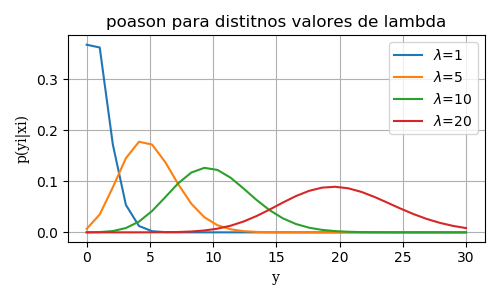

In [5]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True, facecolor='w')
# Tipos de linea: -, --, -., :, none
# Tipos de markers: .,o,x,d,s,1,2,3,4
y = np.linspace(start=0, stop=30, num=30)


#incorporar un intSlider para los valores de lambda?
for i in [1, 5, 10, 20]:
    values = [poisonxd(i, val) for val in y]
    plt.plot(y, values, label=f'$\lambda$={i}')
    
    
ax.set_ylabel('p(yi|xi)', fontsize=10, fontname='serif', color="black")
ax.set_xlabel('y', fontsize=10, fontname='serif', color="black")
ax.set_title('poason para distitnos valores de lambda')    
ax.grid()
ax.legend()
plt.show()

###### Aplique el supuesto iid. Obtenga y muestre una expresión analítica para el logaritmo de la verosimilitud del problema

$$
\begin{align}
\mathcal{L}(\theta) &= \prod_{i=1}^N P(y_i|\theta) \nonumber \\
\mathcal{L}(\theta) &= \prod_{i=1}^N \frac{\lambda_i^{y_i}}{y_i!} e^\left ({-\lambda_i} \right) \nonumber \\
\end{align}
$$
aplicando log se tiene
$$
\begin{align}
\log \mathcal{L}(\theta) &= \sum_{i=1}^N \log (\frac{\lambda_i^{y_i}}{y_i!})-\lambda_i \nonumber \\
\log \mathcal{L}(\theta) &=  \sum_{i=1}^N \log (\lambda_i^{y_i}) - \log (y_i!)-\lambda_i \nonumber \\
\log \mathcal{L}(\theta) &=  \sum_{i=1}^N {y_i} \log (\lambda_i) - \log (y_i!)-\lambda_i \nonumber \\
\end{align}
$$

###### Obtenga y muestre una expresión analítica para la primera deriviada del logaritmo de la verosimilitud


derivada con respecto a  $\theta_0$
$$
\begin{align}
\frac{\partial \log \mathcal{L}(\theta)}{\partial \theta_0}=\sum_{i=1}^N ({y_i} - \lambda_i)
\end{align}
$$

derivada con respecto a  $\theta_j$ con $\mathcal{j}$>0
$$
\begin{align}
\frac{\partial \log \mathcal{L}(\theta)}{\partial \theta_j}=\sum_{i=1}^N (({y_i} - \lambda_i) \sum_{i=1}^M {x_{ij}})
\end{align}
$$


## Implementación

1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`
1. Encuentre el vector de parámetros óptimo usando `scipy.optimize.minimize`, justifique su decisión para el método y argumentos a usar
1. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$
1. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y para el pseudo coeficiente de correlación


In [6]:
Y = df['nbillonarios'].values
x=df.drop(['nbillonarios'], axis=1)
X=x.values

In [7]:
def modelo(theta, X, Y):
    lmbd = np.exp(theta[0] + np.sum(theta[1:]*X, axis=1))
    return poisonxd(lmbd,Y),lmbd

    #f = theta[0] + np.sum(theta[1:]*X, axis=1)     
    #return sigmoide(f), f

In [16]:
def neglogverosimilitud(theta, *args):
    X,Y = args
    P, lmbd = modelo(theta, X,Y)
    
    return -np.sum( (Y*np.log(lmbd+1e-10)-lmbd), axis=0 )
    
    
    
    
    
    
    
    

## Resultados

1. Prediga la cantidad de billonarios de cada país usando su modelo. Muestre la cantidad de billonarios predicha y real para cada continente. ¿Qué puede comentar al respecto?
1. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?
1. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles paises tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?



## Conclusiones

Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 